## Benchmark halo.

In [ ]:
from shared.preface import *
import commah

sim_dir = f'L025N752/DMONLY/SigmaConstant00/low_res_1Halo_plus_benchmark'

# Box parameters and arrays.
with open(f'{sim_dir}/box_parameters.yaml', 'r') as file:
    box_setup = yaml.safe_load(file)
DM_mass = box_setup['Content']['DM Mass [Msun]']*Msun
nums_snaps = np.load(f'{sim_dir}/nums_snaps.npy')
zeds_snaps = np.load(f'{sim_dir}/zeds_snaps.npy')

FCT_h = box_setup['Cosmology']['h']
FCT_H0 = FCT_h*100*km/s/Mpc
FCT_Omega_M = box_setup['Cosmology']['Omega_M']
FCT_Omega_L = box_setup['Cosmology']['Omega_L']

# Get the DM halo mass (and the number of DM particles for sample).
commah_output = commah.run('Planck13', zi=0, Mi=1e8, z=0)
Mz = commah_output['Mz'][0,0]*Msun
num_DM = math.floor(Mz / DM_mass)

# Get the parameters of the halo.
c_200 = commah_output['c'][0,0]
# R_200 = 

ic(commah_output)

ic(f'{Mz/Msun:.2e}')
ic(f'{c_200:.2e}')

In [ ]:
from shared.preface import *
import commah

sim_dir = f'L025N752/DMONLY/SigmaConstant00/high_res_1Halo'

# Box parameters and arrays.
with open(f'{sim_dir}/box_parameters.yaml', 'r') as file:
    box_setup = yaml.safe_load(file)
DM_mass = box_setup['Content']['DM Mass [Msun]']*Msun
nums_snaps = np.load(f'{sim_dir}/nums_snaps.npy')
zeds_snaps = np.load(f'{sim_dir}/zeds_snaps.npy')

FCT_h = box_setup['Cosmology']['h']
FCT_H0 = FCT_h*100*km/s/Mpc
FCT_Omega_M = box_setup['Cosmology']['Omega_M']
FCT_Omega_L = box_setup['Cosmology']['Omega_L']

@nb.njit
def rho_crit(z):
    """Critical density of the universe as a function of redshift, assuming
    matter domination, only Omega_m and Omega_Lambda in Friedmann equation. See 
    notes for derivation.

    Args:
        z (array): redshift

    Returns:
        array: critical density at redshift z
    """    
    
    H_squared = FCT_H0**2 * (FCT_Omega_M*(1.+z)**3 + FCT_Omega_L) 
    rho_crit = 3.*H_squared / (8.*Pi*G)

    return np.float64(rho_crit)


def halo_sample_z(z, snap, Mvir_z0, DM_mass, out_dir, origin_offset=0.):

    # Get the DM halo mass (and the number of DM particles for sample).
    commah_output = commah.run('Planck13', zi=0, Mi=Mvir_z0, z=z)
    Mz = commah_output['Mz'][0,0]*Msun
    num_DM = math.floor(Mz / DM_mass)

    # Get the concentration of the halo.
    c_200 = commah_output['c'][0,0]

    # Calculate R_200 and R_s ("virial" radius and scale radius).
    R_200 = np.power(Mz / (200*rho_crit(z)*4/3*Pi), 1./3.)
    R_s = R_200 / c_200

    # Construct projection function.
    def Proj(r, r_s, norm):
        x = r/r_s
        return (np.log(1+x) - (x/(1+x)))/norm

    # Construct inverse function. Needs to be without numerical units.
    f_200 = np.log(1+c_200) - (c_200/(1+c_200))
    invf = inversefunc(Proj, args=(R_s/kpc, f_200))  

    # Sample uniformly between [0,1] and project to corresponding radius.
    sample = np.sort(np.random.uniform(size=num_DM))
    r_sample = invf(sample)

    # Sample for angles and convert to cartesian DM_coords.
    phis = np.random.uniform(0, 2*Pi, num_DM)  # uniform [0,2pi)
    cos_thetas = 2.*np.random.uniform(0, 1, num_DM) - 1  # uniform [-1,1)

    # Convert to cartesian coordinates.
    x = r_sample*np.cos(phis)*np.sqrt(1. - cos_thetas**2)
    y = r_sample*np.sin(phis)*np.sqrt(1. - cos_thetas**2)
    z = r_sample*cos_thetas
    coords = np.column_stack((x,y,z)) + origin_offset

    np.save(f'{out_dir}/benchmark_halo_snap_{snap}.npy', coords)


benchmark_outdir = f'L025N752/DMONLY/SigmaConstant00/benchmark_halo_files'
if not os.path.exists(benchmark_outdir):
    os.makedirs(benchmark_outdir)


# Generate 2 NFW halos: 10^12 host halo and 10^8 subhalo some offset away.
subhalo_offset = np.array([0, 40, 8])*kpc
with ProcessPoolExecutor(24) as ex:
    ex.map(
        halo_sample_z, zeds_snaps, nums_snaps,
        repeat(Mvir_MW/Msun), repeat(DM_mass), repeat(benchmark_outdir),
        repeat(subhalo_offset)

    )

In [ ]:
benchmark_DM = np.array([
    len(np.load(f'{benchmark_outdir}/benchmark_halo_snap_{num}.npy')) 
    for num in nums_snaps
])

print(np.log10(Mvir_MW/Msun), np.log10(DM_mass*benchmark_DM[-1]/Msun))

nums_proxy = np.arange(12, 36+1)
plt.plot(nums_proxy, benchmark_DM); plt.show()

## Load, transform and plot simulation outputs.

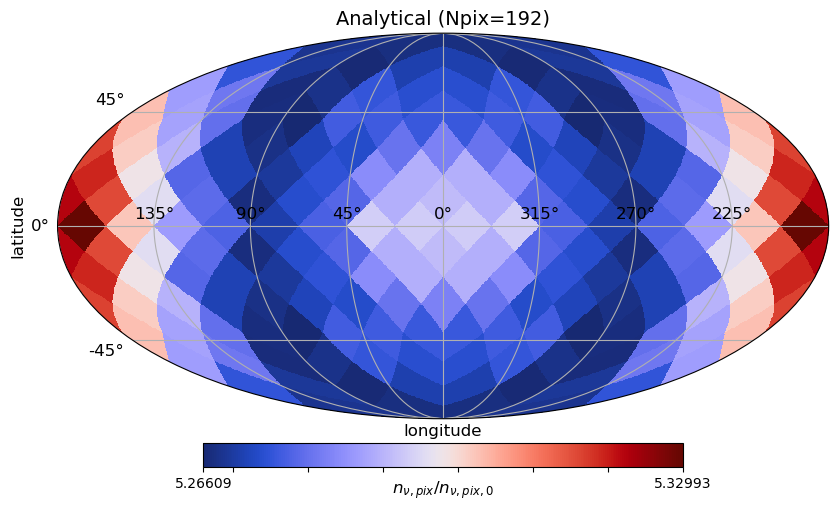

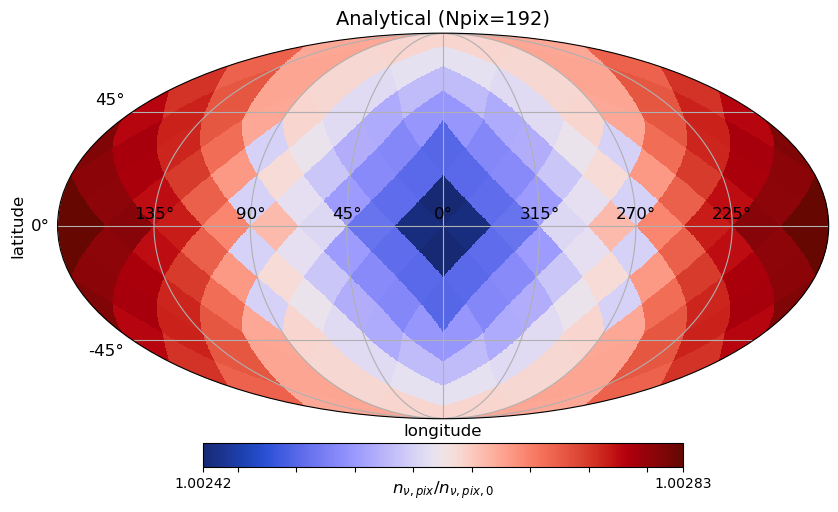

array([1.0026742 , 1.00264181, 1.00264181, 1.0026742 , 1.00272208,
       1.00267659, 1.00264115, 1.00261655, 1.00261655, 1.00264115,
       1.00267659, 1.00272208, 1.00275496, 1.00272982, 1.00267607,
       1.00264131, 1.00261047, 1.00258156, 1.00258156, 1.00261047,
       1.00264131, 1.00267607, 1.00272982, 1.00275496, 1.00278024,
       1.00276375, 1.00273015, 1.00267467, 1.00264169, 1.00261019,
       1.00256755, 1.0025473 , 1.0025473 , 1.00256755, 1.00261019,
       1.00264169, 1.00267467, 1.00273015, 1.00276375, 1.00278024,
       1.00281386, 1.00278999, 1.00276263, 1.00271502, 1.00260132,
       1.00262129, 1.00256915, 1.00253417, 1.00249929, 1.00253417,
       1.00256915, 1.00262129, 1.00260132, 1.00271502, 1.00276263,
       1.00278999, 1.00280683, 1.00278773, 1.00274866, 1.00268414,
       1.00263815, 1.0025904 , 1.00253741, 1.00250247, 1.00250247,
       1.00253741, 1.0025904 , 1.00263815, 1.00268414, 1.00274866,
       1.00278773, 1.00280683, 1.00283019, 1.00280501, 1.00277

In [3]:
from shared.preface import *
from shared.shared_functions import *
from shared.plot_class import analyze_simulation_outputs
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

class analyze_simulation_outputs_test(object):

    def __init__(self, sim_dir, objects, sim_type):

        # Required:
        self.sim_dir = sim_dir
        self.objects = objects
        self.sim_type = sim_type
        
        self.fig_dir = f'figures/{sim_dir}'
        if not os.path.exists(self.fig_dir):
            os.makedirs(self.fig_dir)


        # Neccessary arrays.
        self.mrange = np.load(f'{self.sim_dir}/neutrino_massrange_eV.npy')*eV
        self.mpicks = np.array([0.01, 0.05, 0.1, 0.3])

        if self.sim_type == 'single_halos':

            if 'NFW_halo' in self.objects:

                batch_paths = glob.glob(
                    f'{self.sim_dir}/neutrino_vectors_numerical_benchmark_halo_batch*.npy'
                )
                
                self.vectors_benchmark = []
                for batch_path in batch_paths:
                    self.vectors_benchmark.append(np.load(batch_path))
                self.vectors_benchmark = np.squeeze(
                    np.array(self.vectors_benchmark)
                )
                self.vectors_benchmark = np.array(self.vectors_benchmark)

                self.etas_benchmark = np.load(
                    f'{self.sim_dir}/number_densities_numerical_benchmark_halo.npy'
                )/N0


            if 'box_halos' in self.objects:
                
                self.etas_numerical = []
                self.vectors_numerical = []

                halo_num = len(np.load(
                    glob.glob(f'{self.sim_dir}/halo*params.npy')[0]
                ))

                for halo in range(1, halo_num+1): 
                    
                    # Find all batch paths belonging to current halo.
                    batch_paths = glob.glob(
                        f'{self.sim_dir}/neutrino_vectors_numerical_halo{halo}_batch*.npy'
                    )

                    # Concatenate all vector batches into one array.
                    vectors_halo = []
                    for batch_path in batch_paths:
                        vectors_halo.append(np.load(batch_path))
                    vectors_halo = np.squeeze(np.array(vectors_halo))

                    # Append vectors.
                    self.vectors_numerical.append(vectors_halo)

                    # Append overdensities.
                    self.etas_numerical.append(
                        np.load(
                            f'{self.sim_dir}/number_densities_numerical_halo{halo}.npy'
                        )/N0
                    )

                self.etas_numerical = np.array(self.etas_numerical)
                self.vectors_numerical = np.array(self.vectors_numerical)


            if 'analytical_halo' in self.objects:

                batch_paths = glob.glob(
                    f'{self.sim_dir}/neutrino_vectors_analytical_batch*.npy'
                )
                
                self.vectors_analytical = []
                for batch_path in batch_paths:
                    self.vectors_analytical.append(np.load(batch_path))
                self.vectors_analytical = np.squeeze(
                    np.array(self.vectors_analytical)
                )
                self.vectors_analytical = np.array(self.vectors_analytical)

                self.etas_analytical = np.load(
                    f'{self.sim_dir}/number_densities_analytical_single_halos.npy'
                )/N0


        elif self.sim_type == 'all_sky':

            if 'box_halos' in self.objects:

                self.number_densities_numerical_all_sky = []

                halo_num = len(np.load(
                    glob.glob(f'{self.sim_dir}/halo*params.npy')[0]
                ))

                for halo in range(1, halo_num+1):
                    
                    # Append overdensities.
                    self.number_densities_numerical_all_sky.append(
                        np.load(
                            f'{self.sim_dir}/number_densities_numerical_halo{halo}_all_sky.npy'
                        )
                    )

                self.number_densities_numerical_all_sky = np.array(
                    self.number_densities_numerical_all_sky
                )


            if 'NFW_halo' in self.objects:

                self.number_densities_numerical_all_sky = np.load(
                    f'{self.sim_dir}/number_densities_numerical_benchmark_halo_all_sky.npy'
                )[np.newaxis,...]


            if 'analytical_halo' in self.objects:

                self.number_densities_analytical_all_sky = np.load(
                    f'{self.sim_dir}/number_densities_analytical_all_sky.npy'
                )


    def rotate_DM(self, DM_pos, obs_pos):

        # Calculate the Euler angles, to match frame of Earth. This will be the 
        # new frame in which DM particles get projected to an all sky map.
        zAngle = np.arctan2(obs_pos[1], -obs_pos[0])
        yAngle = np.arctan2(-obs_pos[2], np.linalg.norm(obs_pos[:2]))
        print('*** Angles: ***')
        print(np.rad2deg(zAngle), np.rad2deg(yAngle))

        cz = np.cos(zAngle)
        sz = np.sin(zAngle)
        cy = np.cos(yAngle)
        sy = np.sin(yAngle)

        R_z = np.array([
            [cz, -sz, 0],
            [sz, cz,  0],
            [0,  0,   1]
        ])
        R_y = np.array([
            [cy,  0, sy],
            [0,   1,  0],
            [-sy, 0, cy]
        ])

        rot_mat = np.matmul(R_y, R_z)

        # Observer position in nex frame (aligned with x-axis).
        obs_orig_in_rot_frame = np.matmul(rot_mat, obs_pos.T).T

        # Dark matter positions in observer frame.
        DM_orig_in_rot_frame = np.matmul(rot_mat, DM_pos.T).T

        return DM_orig_in_rot_frame, obs_orig_in_rot_frame


    def plot_all_sky_map(
            self, nu_mass_eV, sim_method, DM_num, halo=None, two_plots=False
        ):

        savefig_args = dict(
            bbox_inches='tight'
        )
        nu_mass_idx = (np.abs(self.mrange-nu_mass_eV)).argmin()

        with open(f'{self.sim_dir}/sim_parameters.yaml', 'r') as file:
            sim_setup = yaml.safe_load(file)

        # Automatic.
        Nside = sim_setup['Nside']
        Npix = sim_setup['Npix']
        pix_sr = sim_setup['pix_sr']
        N0_pix = N0/Npix

        # print(np.rad2deg(pix_sr))
        reso = hp.nside2resol(Nside, arcmin=True) / 60

        if sim_method == 'analytical':

            dens_nu = self.number_densities_analytical_all_sky[...,nu_mass_idx]
            etas_nu = dens_nu/N0_pix

            healpix_map = etas_nu

            # Create a grid of (theta, phi) coordinates for the map
            theta, phi = hp.pix2ang(Nside, np.arange(len(healpix_map)))

            rot = hp.rotator.Rotator(
                rot=[-180, 0], deg=True, eulertype='ZYX', inv=False
            )

            # Apply rotation to the grid
            theta_rot, phi_rot = rot(theta, phi)

            # Find the pixel indices of the rotated grid
            pix_rot = hp.ang2pix(Nside, theta_rot, phi_rot)

            # Create a new map with rotated pixel values
            rotated_map = np.zeros_like(healpix_map)
            rotated_map[pix_rot] = healpix_map

            hp.newvisufunc.projview(
                rotated_map,
                coord=['G'],
                title=f'Analytical (Npix={Npix})',
                unit=r'$n_{\nu, pix} / n_{\nu, pix, 0}$',
                cmap=cc.cm.CET_D1A,
                graticule=True,
                graticule_labels=True,
                xlabel="longitude",
                ylabel="latitude",
                cb_orientation="horizontal",
                projection_type="mollweide",
                flip='astro',
                # cbar_ticks=[],
                show_tickmarkers=True,
                latitude_grid_spacing=45,
                longitude_grid_spacing=45,
                alpha=1,
                phi_convention='counterclockwise',
                # min=0.7,
                # max=5.5
            )

            plt.savefig(
                f'{self.fig_dir}/All_sky_map_analytical_{nu_mass_eV}eV.pdf', 
                **savefig_args
            )
            plt.show()
            plt.close()

            return healpix_map

        if sim_method == 'numerical':

            # halo_params = np.load(
            #     glob.glob(f'{self.sim_dir}/halo*params.npy')[0]
            # )
            # Mvir = halo_params[halo-1,1]
            
            # Initial pixel array.
            dens_nu = self.number_densities_numerical_all_sky[...,nu_mass_idx]
            etas_nu = dens_nu/N0_pix
            healpix_map = etas_nu[halo-1,...]

            fig = plt.figure(figsize =(12, 6))

            if two_plots:

                # Axis 1 params.
                ax1 = fig.add_subplot(121)
                ax1.spines['top'].set_visible(False)
                ax1.spines['right'].set_visible(False)
                ax1.spines['bottom'].set_visible(False)
                ax1.spines['left'].set_visible(False)
                ax1.get_xaxis().set_ticks([])
                ax1.get_yaxis().set_ticks([])
                subax1 = 121

                # Axis 2 params.
                # ax2 = fig.add_subplot(122, projection='3d')
                ax2 = fig.add_subplot(122)
                ax2.spines['top'].set_visible(False)
                ax2.spines['right'].set_visible(False)
                ax2.spines['bottom'].set_visible(False)
                ax2.spines['left'].set_visible(False)
                ax2.get_xaxis().set_ticks([])
                ax2.get_yaxis().set_ticks([])
                subax2 = 122
            else:

                ax1 = fig.add_subplot(111)
                ax1.spines['top'].set_visible(False)
                ax1.spines['right'].set_visible(False)
                ax1.spines['bottom'].set_visible(False)
                ax1.spines['left'].set_visible(False)
                ax1.get_xaxis().set_ticks([])
                ax1.get_yaxis().set_ticks([])
                subax1 = 111


            # Create a grid of (theta, phi) coordinates for the map
            theta, phi = hp.pix2ang(Nside, np.arange(len(healpix_map)))


            if halo == 0:
                end_str = f'benchmark_halo'
            else:
                end_str = f'halo{halo}'

            init_xyz = np.load(f'{self.sim_dir}/init_xyz_{end_str}.npy')
            print(f'*** Initial cell coordinates: ***')
            print(init_xyz)
            print(np.linalg.norm(init_xyz))
            print(f'*** ========================= ***')

            zAngle = np.rad2deg(
                np.arctan2(init_xyz[1], -init_xyz[0])
            )
            yAngle = np.rad2deg(
                np.arctan2(-init_xyz[2], np.linalg.norm(init_xyz[:2]))
            )
            ic(zAngle, yAngle)
            rot = hp.rotator.Rotator(
                rot=[-zAngle, yAngle, 0], deg=True, eulertype='ZYX', inv=False
            )

            # Apply rotation to the grid
            theta_rot, phi_rot = rot(theta, phi)

            # Find the pixel indices of the rotated grid
            pix_rot = hp.ang2pix(Nside, theta_rot, phi_rot)

            # Create a new map with rotated pixel values
            rotated_map = np.zeros_like(healpix_map)
            rotated_map[pix_rot] = healpix_map

            # Find zero-valued pixels and interpolate their values from 4 neighbors
            zero_pixels = np.where(rotated_map == 0)[0]
            for pix in zero_pixels:
                theta_zero, phi_zero = hp.pix2ang(Nside, pix)
                interp_val = hp.get_interp_val(
                    healpix_map, theta_zero, phi_zero
                )
                rotated_map[pix] = interp_val

            # Smooth the rotated map using a Gaussian kernel
            smooth_sigma_deg = reso/4.
            smooth_sigma_rad = np.deg2rad(smooth_sigma_deg)
            smooth_rot_map = hp.smoothing(rotated_map, sigma=smooth_sigma_rad)

            # Make center value to be 1 (no overdensity).
            divnorm = mcolors.TwoSlopeNorm(vcenter=1.)

            hp.newvisufunc.projview(
                # smooth_rot_map,
                rotated_map,
                coord=['G'],
                title=f'Numerical, {end_str} (Npix={Npix})',
                unit=r'$n_{\nu, pix} / n_{\nu, pix, 0}$',
                cmap=cc.cm.CET_D1A,
                graticule=True,
                graticule_labels=True,
                xlabel="longitude",
                ylabel="latitude",
                cb_orientation="horizontal",
                projection_type="mollweide",
                flip='astro',
                show_tickmarkers=True,
                latitude_grid_spacing=45,
                longitude_grid_spacing=45,
                alpha=1,
                phi_convention='counterclockwise',
                sub=subax1,
                # norm=divnorm,
            )


            if two_plots:

                hp.newvisufunc.projview(
                    np.zeros_like(healpix_map),
                    coord=['G'],
                    title=f'Numerical, {end_str} (Npix={Npix})',
                    unit='a.u.',
                    cmap=cc.cm.gray_r,
                    graticule=True,
                    graticule_labels=True,
                    xlabel="longitude",
                    ylabel="latitude",
                    cb_orientation="horizontal",
                    projection_type="mollweide",
                    flip='astro',
                    latitude_grid_spacing=45,
                    longitude_grid_spacing=45,
                    cbar=False,
                    alpha=1,
                    phi_convention='counterclockwise',
                    sub=subax2
                )
                
                # Load Halo DM positions.
                if DM_num is None:
                    pos_origin = np.load(
                        'L025N752/DMONLY/SigmaConstant00/benchmark_halo_files/benchmark_halo_snap_0036.npy'
                    )
                    DM_num = 'NFW'
                else:
                    pos_origin = np.load(
                        f'DM_pos_for_plots/DM_pos_halo_with_{DM_num}.npy'
                    )

                # Rotate DM to bring CoP of halo to origin (middle) in plot.
                DM_rot, obs_rot = self.rotate_DM(pos_origin, init_xyz)
                print('*** rotated initial coordinates ***')
                print(obs_rot)

                # Center on observer position.
                DM_pos = DM_rot - obs_rot
                xDM, yDM, zDM = DM_pos[:,0], DM_pos[:,1], DM_pos[:,2]

                # Load precalculated densities.
                density = np.load(
                    f'DM_pos_for_plots/DM_densities_halo_with_{DM_num}.npy'
                )

                # Sort the points by density (densest points are plotted last)
                idx = density.argsort()
                xDM,yDM,zDM, density = xDM[idx],yDM[idx],zDM[idx], density[idx]

                # Convert x,y,z to angles.
                proj_xy_plane_dis = np.sqrt(xDM**2 + yDM**2)

                thetas = np.arctan2(zDM, proj_xy_plane_dis)
                phis = np.arctan2(yDM, xDM)

                # note: scatter has inverse x-axis, must take -phis (tested)
                plt_phi, plt_theta = -phis, thetas

                # Thin out plotted particles.
                step = 20
                plt.scatter(
                    plt_phi[::step], plt_theta[::step], c=density[::step],
                    cmap=cc.cm.CET_L7_r, s=20, alpha=0.4
                )

            plt.savefig(
                f'{self.fig_dir}/All_sky_maps_{end_str}.pdf', 
                **savefig_args
            )
            plt.show()
            plt.close()

            return healpix_map


    def plot_neutrinos_inside_Rvir(self):
        
        # All positions and velocities across redshifts.
        pos = self.vectors_numerical[...,0:3]
        vel = self.vectors_numerical[...,3:6]
        # (halos, neutrinos, z_int_steps, 3)

        # Radii and velocity magnitudes.
        rad = np.sqrt(np.sum(pos**2, axis=-1))
        mag = np.sqrt(np.sum(vel**2, axis=-1))

        if mag.shape[0] < 100:
            nu_axis = 1
        else:
            nu_axis = 0
        neutrinos = mag.shape[nu_axis]
        
        # Read R_vir of halo sample.
        halo_params = np.load(
            glob.glob(f'{self.sim_dir}/halo*params.npy')[0]
        )

        # Halo sample starting (z=0) parameters.
        R_vir_sample_z0 = halo_params[:,0]
        M_vir_sample = 10**halo_params[:,1]

        
        tree_path = f'{self.sim_dir}/MergerTree.hdf5'
        halo_IDs = np.load(glob.glob(f'{self.sim_dir}/halo*indices.npy')[0])
        # ic(halo_IDs)

        with h5py.File(tree_path) as tree:
            # ic(tree['Assembly_history'].keys())

            inds = list(halo_IDs.flatten())
            Masses_box = np.take(
                np.array(tree['Assembly_history/Mass']), inds, axis=0)
            Masses = np.asarray(Masses_box)*Msun

            zeds_box = tree['Assembly_history/Redshift']
            zeds = np.asarray(zeds_box)


            # Box parameters.
            with open(f'{self.sim_dir}/box_parameters.yaml', 'r') as file:
                box_setup = yaml.safe_load(file)
            H0 = box_setup['Cosmology']['h']*100*km/s/Mpc
            Omega_M = box_setup['Cosmology']['Omega_M']
            Omega_L = box_setup['Cosmology']['Omega_L']

            # Calculate evolution of R_vir of halo sample.
            R_vir_l = []
            for z, Mz in zip(zeds, Masses):
                rho_c = fct_rho_crit(z, H0, Omega_M, Omega_L)
                R_vir_l.append(np.power(Mz / (200*rho_c*4/3*Pi), 1./3.))
        
        R_vir_sample = np.array(R_vir_l)

        # Select only values at box snapshots
        z_int_steps = np.load(f'{self.sim_dir}/z_int_steps.npy')
        snap_ids = [np.abs(z_int_steps - z).argmin() for z in zeds]
        rad_snaps = rad[...,snap_ids]

        cond = (rad_snaps <= R_vir_sample[:, np.newaxis, :]/kpc)
        perc_in_Rvir = np.count_nonzero(cond, axis=nu_axis)/neutrinos*100

        '''
        # Escape velocity at redshift z, dependent on halo parameters.
        # Read in R_vir, R_s and rho_0. x_i will be R_vir

        v_esc = escape_momentum_analytical(x_i, R_vir, R_s, rho_0, None)

        # MW_esc = 550  # km/s         
        
        esc_cond = (mag*(kpc/s)/(km/s) <= MW_esc)
        # vals, esc_num = np.unique(esc_cond, return_counts=True, axis=0)
        perc_in_Rvir = np.count_nonzero(esc_cond, axis=nu_axis)/neutrinos*100
        print(perc_in_Rvir.shape)
        # '''


        for i, perc_curve in enumerate(perc_in_Rvir):
            plt.semilogx(
                1+zeds, perc_curve, label=f'Mvir = {M_vir_sample[i]:.2e}'
            )

        # Plot specific redshift markers.
        plt.axvline(1+0.5, c='red', ls='-.', label='z=0.5')
        plt.axvline(1+1., c='orange', ls='-.', label='z=1')

        # plt.ylim(50, 60)
        plt.xlabel('z')
        plt.ylabel('%')
        plt.title(r'% of $\nu$ inside $R_{vir}$')
        plt.legend()
        plt.show()


'''
sim_dir = f'L025N752/DMONLY/SigmaConstant00/low_res_1Halo_plus_benchmark'
objects = (
    # 'NFW_halo', 
    'box_halos', 
    # 'analytical_halo'
)
Analysis = analyze_simulation_outputs_test(
    sim_dir = sim_dir,
    objects = objects,
    sim_type = 'single_halos',
)
Analysis.plot_neutrinos_inside_Rvir()
# '''


'''
sim_dir = f'L025N752/DMONLY/SigmaConstant00/all_sky_final'
objects = (
    # 'NFW_halo', 
    'box_halos', 
    # 'analytical_halo'
)
Analysis = analyze_simulation_outputs_test(
    sim_dir = sim_dir,
    objects = objects,
    sim_type = 'all_sky',
)
halos = [
    1, 
    2, 
    3, 
    4, 
    5
]
DM_nums = [
    167745, 
    177824, 
    235953, 
    520305, 
    947546
]
for halo, DM_num in zip(halos, DM_nums):
    Analysis.plot_all_sky_map(0.01, 'numerical', DM_num, halo, two_plots=False)
# '''

'''
sim_dir = f'L025N752/DMONLY/SigmaConstant00/all_sky_control'
objects = (
    'NFW_halo', 
    # 'box_halos', 
    # 'analytical_halo'
)
Analysis = analyze_simulation_outputs_test(
    sim_dir = sim_dir,
    objects = objects,
    sim_type = 'all_sky',
)
Analysis.plot_all_sky_map(0.3, 'numerical', None, halo=0, two_plots=False)
# '''


# '''
sim_dir = f'L025N752/DMONLY/SigmaConstant00/all_sky_control'
objects = (
    # 'NFW_halo', 
    # 'box_halos', 
    'analytical_halo'
)
Analysis = analyze_simulation_outputs_test(
    sim_dir = sim_dir,
    objects = objects,
    sim_type = 'all_sky',
)
Analysis.plot_all_sky_map(0.3, 'analytical', None, halo=0, two_plots=False)
Analysis.plot_all_sky_map(0.01, 'analytical', None, halo=0, two_plots=False)
# '''

In [ ]:

'''
# Calculate density kernel with a library.

# Randomly subsample your data
sample_fraction = 0.01  # Fraction of data points to keep
n_samples = len(xyz)
n_subsamples = int(n_samples * sample_fraction)
subsample_indices = np.random.choice(
    n_samples, n_subsamples, replace=False
)
xyz_subsampled = xyz[subsample_indices]

# Create and fit the KernelDensity model using the subsampled data
kde = KernelDensity(
    kernel='gaussian', bandwidth=0.5
).fit(xyz_subsampled)

# Evaluate the density at the original data points
density_log = kde.score_samples(xyz)
density = np.exp(density_log)  

ic(density_log.min(), density_log.max())

# Get density from Camila's files.
with open(f'{self.sim_dir}/box_parameters.yaml', 'r') as file:
    box_setup = yaml.safe_load(file)

box_file_dir = box_setup['File Paths']['Box File Directory']
snaps = h5py.File(f'{box_file_dir}/snapshot_0036.hdf5')
dens = snaps['PartType1/Densities']
print(dens.attrs.keys())

cf = dens.attrs['Conversion factor to physical CGS (including cosmological corrections)']



indices_p = np.load(
    f'{self.sim_dir}/temp_data_TEST/DM_pos_indices_origID28_snap_0036.npy'
)

density = np.array(dens)[indices_p] * cf
# '''


'''
sim_dir = f'L025N752/DMONLY/SigmaConstant00/all_sky_high_res_TEST'
objects = (
    # 'NFW_halo', 
    'box_halos', 
    # 'analytical_halo'
)
Analysis = analyze_simulation_outputs_test(
    sim_dir = sim_dir,
    objects = objects,
    sim_type = 'all_sky'
)
# halo_num = 5
# for i in range(1,halo_num+1): 
#     healpix_map = Analysis.plot_all_sky_map(
#         nu_mass_eV=0.3, sim_method='numerical', DM_num=0, halo=i
#     )

healpix_map = Analysis.plot_all_sky_map(
    nu_mass_eV=0.3, sim_method='numerical', DM_num=167745, halo=3, 
    two_plots=True
)

# halos = [1,2,3,4,5]
# DM_nums = [520305, 235953, 167745, 177824, 947546]
# with ProcessPoolExecutor(5) as ex:
#     ex.map(
#         Analysis.plot_all_sky_map, repeat(0.3), repeat('numerical'), 
#         DM_nums, halos 
#     )
# '''